In [231]:
import pandas as pd
import numpy as np
from functions_NLM import estimate_nested_logit
import matplotlib.pyplot as plt

<h2> CNLM with alpha as variable </h2>

In [232]:
# Define log-likelihood function for telephone data
# beta will be beta = ["ASC_1", "ASC_3", "ASC_4", "ASC_5",
#                       "BETA_COST", "lambda_measured", "lambda_flat", "alpha_3_with_measured"]

# before ["ASC_CAR", "ASC_SM", "BETA_TT", "BETA_TC", "lambda_CAR_TRAIN", "lambda_SM_TRAIN", "base_alpha_TRAIN_WITH_CAR"]

# DEFINE MODEL STRUCTURE AND LIKELIHOOD FUNCTION
def log_likelihood_telephone_CNLM(beta, data):
    alpha_3_with_measured = np.exp(beta[7]) / (1 + np.exp(beta[7]))
    alpha_3_with_flat = 1 - alpha_3_with_measured

    # Define utility functions
    data['U_1'] = beta[0] + beta[4] * data['logcost1']
    data['U_2'] = beta[4] * data['logcost2']
    data['U_3'] = beta[1] + beta[4] * data['logcost3']
    data['U_4'] = beta[2] + beta[4] * data['logcost4']
    data['U_5'] = beta[3] + beta[4] * data['logcost5']

    # combined utility terms inside nests
    data['log_U_measured_3'] = np.log((alpha_3_with_measured * data['avail3'] * np.exp(data['U_3'])) ** (1 / beta[5]) + \
                             data['avail1'] * np.exp(data['U_1']) ** (1 / beta[5]) + \
                             data['avail2'] * np.exp(data['U_2']) ** (1 / beta[5]))
    data['log_U_flat_3'] = np.log((alpha_3_with_flat * data['avail3'] * np.exp(data['U_3'])) ** (1 / beta[6]) + \
                            data['avail4'] * np.exp(data['U_4']) ** (1 / beta[6]) + \
                            data['avail5'] * np.exp(data['U_5']) ** (1 / beta[6]))

    # Nest probabilities
    data['log_P_nest_measured_3'] = data['log_U_measured_3'] * beta[5] - \
                                np.log(np.exp(data['log_U_measured_3']) ** beta[5] + \
                                       np.exp(data['log_U_flat_3']) ** beta[6])
    data['log_P_nest_flat_3'] = np.log(1 - np.exp(data['log_P_nest_measured_3']))

    # Within nest probabilities
    data['log_P_1_in_measured_3'] = np.log(data['avail1']) + data['U_1'] / beta[5] - data['log_U_measured_3']
    data['log_P_3_in_measured_3'] = (np.log(data['avail3']) + np.log(alpha_3_with_measured) + \
                                     data['U_3']) / beta[5] - data['log_U_measured_3']
    data['log_P_2_in_measured_3'] = np.log(1 - np.exp(data['log_P_1_in_measured_3']) - \
                                           np.exp(data['log_P_3_in_measured_3']))
    data['log_P_4_in_flat_3'] = np.where(data['avail4'] == 0, -np.inf,
                                     np.log(data['avail4']) + data['U_4'] / beta[6] - data['log_U_flat_3'])
    data['log_P_3_in_flat_3'] = (np.log(data['avail3']) + np.log(alpha_3_with_flat) + \
                                 data['U_3']) / beta[6] - data['log_U_flat_3']
    data['log_P_5_in_flat_3'] = np.where(data['avail5'] == 0, -np.inf, 
                                         np.log(1 - np.exp(data['log_P_4_in_flat_3']) - \
                                                np.exp(data['log_P_3_in_flat_3'])))

    # Full probabilities
    data['P_1'] = np.exp(data['log_P_nest_measured_3'] + data['log_P_1_in_measured_3'])
    data['P_2'] = np.exp(data['log_P_nest_measured_3'] + data['log_P_2_in_measured_3'])
    data['P_3'] = np.exp(data['log_P_nest_measured_3'] + data['log_P_3_in_measured_3']) + \
                np.exp(data['log_P_nest_flat_3'] + data['log_P_3_in_flat_3'])
    data['P_4'] = np.exp(data['log_P_nest_flat_3'] + data['log_P_4_in_flat_3'])
    data['P_5'] = np.exp(data['log_P_nest_flat_3'] + data['log_P_5_in_flat_3'])

    # Calculate probability for chosen alternative for each row
    data['P'] = (data['choice'] == 1) * data['P_1'] + \
                (data['choice'] == 2) * data['P_2'] + \
                (data['choice'] == 3) * data['P_3'] + \
                (data['choice'] == 4) * data['P_4'] + \
                (data['choice'] == 5) * data['P_5']

    # Calculate log-likelihood 
    LL = data['P'].apply(np.log).sum()

    return -LL  # We minimize negative log-likelihood

In [233]:
# Load data
data = pd.read_csv('./data/telephone.dat', sep='\t')

data['logcost1'] = np.log(data['cost1'])
data['logcost2'] = np.log(data['cost2'])
data['logcost3'] = np.log(data['cost3'])
data['logcost4'] = np.log(data['cost4'])
data['logcost5'] = np.log(data['cost5'])

# Define model parameters
beta = np.array([0, 0, 0, 0, 0, 1, 1, 0])
# lambda_n = 1 / mu_n is a measure of the degree of independence in unobserved utility among
# the alternatives in nest n.
# It should be between 0 and 1 with lambda_n = 1 indicating full independence.
beta_names = ["ASC_1", "ASC_3", "ASC_4", "ASC_5", "BETA_COST", "lambda_measured", "lambda_flat", "alpha_3_with_measured"]


In [234]:
# Estimate parameters
result, se, t_stat, p_value, aic, bic  = estimate_nested_logit(data, beta, beta_names, log_likelihood_telephone_CNLM)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encount

Optimization Results:
               Parameter  Estimate  Robust Asymptotic SE  t-statistic  \
0                  ASC_1 -0.359814              0.134431    -2.676576   
1                  ASC_3  0.943294              0.153933     6.127955   
2                  ASC_4  0.813541              0.394506     2.062175   
3                  ASC_5  1.347388              0.344660     3.909329   
4              BETA_COST -1.432711              0.342982    -4.177216   
5        lambda_measured  0.459973              0.154012     2.986609   
6            lambda_flat  0.412627              0.150258     2.746125   
7  alpha_3_with_measured -2.272236              2.373951    -0.957154   

        p-value  
0  7.724902e-03  
1  2.028538e-09  
2  3.979693e-02  
3  1.076513e-04  
4  3.581415e-05  
5  2.983724e-03  
6  6.285849e-03  
7  3.390326e-01  
AIC: 962.329633587241
BIC: 994.9139898600442


---
---
---
---
---

<h2> CNLM with fixed alpha </h2>

In [235]:
# Define log-likelihood function for telephone data
# beta will be beta = ["ASC_1", "ASC_3", "ASC_4", "ASC_5",
#                       "BETA_COST", "lambda_measured", "lambda_flat"]


# DEFINE LIKELIHOOD FUNCTION
def log_likelihood_telephone_CNLM2(beta, data):
    alpha_3_with_measured = 0.5
    alpha_3_with_flat = 1 - alpha_3_with_measured

    # Define utility functions
    data['U_1'] = beta[0] + beta[4] * data['logcost1']
    data['U_2'] = beta[4] * data['logcost2']
    data['U_3'] = beta[1] + beta[4] * data['logcost3']
    data['U_4'] = beta[2] + beta[4] * data['logcost4']
    data['U_5'] = beta[3] + beta[4] * data['logcost5']

    # combined utility terms inside nests
    data['log_U_measured_3'] = np.log((alpha_3_with_measured * data['avail3'] * np.exp(data['U_3'])) ** (1 / beta[5]) + \
                             data['avail1'] * np.exp(data['U_1']) ** (1 / beta[5]) + \
                             data['avail2'] * np.exp(data['U_2']) ** (1 / beta[5]))
    data['log_U_flat_3'] = np.log((alpha_3_with_flat * data['avail3'] * np.exp(data['U_3'])) ** (1 / beta[6]) + \
                            data['avail4'] * np.exp(data['U_4']) ** (1 / beta[6]) + \
                            data['avail5'] * np.exp(data['U_5']) ** (1 / beta[6]))

    # Nest probabilities
    data['log_P_nest_measured_3'] = data['log_U_measured_3'] * beta[5] - \
                                np.log(np.exp(data['log_U_measured_3']) ** beta[5] + \
                                       np.exp(data['log_U_flat_3']) ** beta[6])
    data['log_P_nest_flat_3'] = np.log(1 - np.exp(data['log_P_nest_measured_3']))

    # Within nest probabilities
    data['log_P_1_in_measured_3'] = np.log(data['avail1']) + data['U_1'] / beta[5] - data['log_U_measured_3']
    data['log_P_3_in_measured_3'] = (np.log(data['avail3']) + np.log(alpha_3_with_measured) + \
                                     data['U_3']) / beta[5] - data['log_U_measured_3']
    data['log_P_2_in_measured_3'] = np.log(1 - np.exp(data['log_P_1_in_measured_3']) - \
                                           np.exp(data['log_P_3_in_measured_3']))
    data['log_P_4_in_flat_3'] = np.where(data['avail4'] == 0, -np.inf,
                                     np.log(data['avail4']) + data['U_4'] / beta[6] - data['log_U_flat_3'])
    data['log_P_3_in_flat_3'] = (np.log(data['avail3']) + np.log(alpha_3_with_flat) + \
                                 data['U_3']) / beta[6] - data['log_U_flat_3']
    data['log_P_5_in_flat_3'] = np.where(data['avail5'] == 0, -np.inf, 
                                         np.log(1 - np.exp(data['log_P_4_in_flat_3']) - \
                                                np.exp(data['log_P_3_in_flat_3'])))

    # Full probabilities
    data['P_1'] = np.exp(data['log_P_nest_measured_3'] + data['log_P_1_in_measured_3'])
    data['P_2'] = np.exp(data['log_P_nest_measured_3'] + data['log_P_2_in_measured_3'])
    data['P_3'] = np.exp(data['log_P_nest_measured_3'] + data['log_P_3_in_measured_3']) + \
                np.exp(data['log_P_nest_flat_3'] + data['log_P_3_in_flat_3'])
    data['P_4'] = np.exp(data['log_P_nest_flat_3'] + data['log_P_4_in_flat_3'])
    data['P_5'] = np.exp(data['log_P_nest_flat_3'] + data['log_P_5_in_flat_3'])

    # Calculate probability for chosen alternative for each row
    data['P'] = (data['choice'] == 1) * data['P_1'] + \
                (data['choice'] == 2) * data['P_2'] + \
                (data['choice'] == 3) * data['P_3'] + \
                (data['choice'] == 4) * data['P_4'] + \
                (data['choice'] == 5) * data['P_5']

    # Calculate log-likelihood 
    LL = data['P'].apply(np.log).sum()

    return -LL  # We minimize negative log-likelihood

In [236]:
# Load data
data = pd.read_csv('./data/telephone.dat', sep='\t')

data['logcost1'] = np.log(data['cost1'])
data['logcost2'] = np.log(data['cost2'])
data['logcost3'] = np.log(data['cost3'])
data['logcost4'] = np.log(data['cost4'])
data['logcost5'] = np.log(data['cost5'])

# Define model parameters
beta = np.array([0, 0, 0, 0, 0, 1, 1])
# lambda_n = 1 / mu_n is a measure of the degree of independence in unobserved utility among
# the alternatives in nest n.
# It should be between 0 and 1 with lambda_n = 1 indicating full independence.
beta_names = ["ASC_1", "ASC_3", "ASC_4", "ASC_5", "BETA_COST", "lambda_measured", "lambda_flat"]


In [237]:
# Estimate parameters
result, se, t_stat, p_value, aic, bic  = estimate_nested_logit(data, beta, beta_names, log_likelihood_telephone_CNLM2)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encount

Optimization Results:
         Parameter  Estimate  Robust Asymptotic SE  t-statistic       p-value
0            ASC_1 -1.635754              0.496645    -3.293610  1.071442e-03
1            ASC_3  2.199670              0.556739     3.950990  9.104589e-05
2            ASC_4  2.426402              1.316582     1.842956  6.602838e-02
3            ASC_5  4.084728              1.053189     3.878438  1.217014e-04
4        BETA_COST -3.354164              0.582177    -5.761416  1.598521e-08
5  lambda_measured  2.541826              0.624433     4.070612  5.587709e-05
6      lambda_flat  1.957885              0.714936     2.738544  6.429389e-03
AIC: 961.2124055418653
BIC: 989.7237172805682


---
---
---
---
---

<h2> Applying DIB algorithm </h2>

In [238]:
data_logcost = data[['logcost1', 'logcost2', 'logcost3', 'logcost4', 'logcost5']]

# Function to compare rows with a reference row
def count_same_rows(df):
    row_counts = {}

    for index, row in df.iterrows():
        # Convert the row to a tuple to make it hashable
        row_tuple = tuple(row)
        
        # Count the occurrences of the row in the dataframe
        if row_tuple in row_counts:
            row_counts[row_tuple] += 1
        else:
            row_counts[row_tuple] = 1
            
    return row_counts

# Count occurrences of each row
row_counts = count_same_rows(data_logcost)

# Add a new column with probabilities
total_rows = len(data_logcost)
data_logcost['probability'] = data_logcost.apply(lambda row: row_counts[tuple(row)] / total_rows, axis=1)
data_logcost.head()


/var/folders/gk/16047hxn3hdgt8s5qmq_gnqh0000gp/T/ipykernel_15149/1840364846.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_logcost['probability'] = data_logcost.apply(lambda row: row_counts[tuple(row)] / total_rows, axis=1)


,logcost1,logcost2,logcost3,logcost4,logcost5,probability
0,1.761300,1.754404,2.545531,13.815511,3.147595,0.002304
1,1.258461,1.754404,2.507972,13.815511,3.147595,0.002304
2,1.627278,1.754404,2.439735,13.815511,3.342155,0.002304
3,1.558145,1.754404,2.347558,13.815511,3.342155,0.002304
4,2.145931,1.953028,2.662355,13.815511,3.342155,0.002304


In [239]:
p_x = data_logcost['probability'].values
p_y_given_x = data[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].values
p_xy = p_x[:, np.newaxis] * p_y_given_x

# Normalize p_xy 
p_xy /= p_xy.sum()

# Define epsilon value
epsilon = 1e-20

# Add epsilon to elements equal to 0
p_xy[p_xy == 0] += epsilon

In [240]:
from functions_IB import kl_divergence, entropy, mutual_information

<h2> Modified version of the DIB algorithm where the maximum number of clusters is the number of alternatives, not the number of individuals </h2>

In [242]:
def geom_DIB_on_alternatives(p_xy, max_iter=100, beta=0.5, threshold=1e-5):
    """
    Performs the geometric deterministic information bottleneck algorithm for clustering.

    Parameters:
    - p_xy (numpy.ndarray): The joint probability distribution of data points and clusters.
    - max_iter (int): The maximum number of iterations for the algorithm. Default is 100.
    - beta (float): The beta parameter for the algorithm. Default is 0.5.

    Returns:
    - q_t_given_x (numpy.ndarray): The conditional probability distribution of clusters given data points.
    - q_t (numpy.ndarray): The marginal probability distribution of clusters.
    - q_y_given_t (numpy.ndarray): The conditional probability distribution of data points given clusters.
    """
    num_data_points = p_xy.shape[0]
    num_clusters = p_xy.shape[1]
    
    # Initialize f(x) as if each index i is assigned to its own cluster
    #f_x = np.arange(num_data_points)
    f_x = [i % 5 for i in range(num_data_points)]
    f_x = np.array(f_x)

    # Initialization 
    d_xt = np.zeros((num_data_points, num_clusters))
    p_y_given_x = p_xy / np.sum(p_xy, axis=1, keepdims=True)
    p_x = np.sum(p_xy, axis=1)
    
    # Initialize q(t) and q(y|t)
    q_t = np.zeros(num_clusters)
    q_y_given_t = np.zeros((num_clusters, num_clusters))
    for t in range(num_clusters):
        relevant_indices = np.where(f_x == t)[0]
        if len(relevant_indices) > 0:
            q_t[t] = np.sum(p_x[relevant_indices])
            q_y_given_t[t] = np.sum(p_xy[relevant_indices], axis=0) / np.sum(p_x[relevant_indices])
    
    q_t /= np.sum(q_t)  # Normalize q(t)
    #q_t_given_x = np.zeros((num_data_points, num_clusters))
    
    # Iterative algorithm
    # Initalize the objective functions for old and new state
    objective_old = 0
    H_T = entropy(q_t)
    I_TY = mutual_information(q_t.reshape(-1, 1) * q_y_given_t)
    objective_new = H_T - beta * I_TY
    iteration = 0

    #for _ in range(max_iter):
    while (abs(objective_new - objective_old) > threshold and iteration < max_iter):
        
        iteration += 1
        # Compute d, l_beta, and f
        for i in range(num_data_points):
            for j in range(num_clusters):
                d_xt[i, j] = kl_divergence(p_y_given_x[i], q_y_given_t[j])

        l_beta_xt = np.log(q_t) - beta * d_xt
        f_x = np.argmax(l_beta_xt, axis=1)
        
        # Update q_t_given_x
        q_t_given_x = np.eye(num_clusters)[f_x]
        
        # Update q_t and q_y_given_t
        for t in range(num_clusters):
            relevant_indices = np.where(f_x == t)[0]
            if len(relevant_indices) > 0:
                q_t[t] = np.sum(p_x[relevant_indices])
                q_y_given_t[t] = np.sum(p_xy[relevant_indices], axis=0) / np.sum(p_x[relevant_indices])
        
        # Normalize q(t)
        q_t /= np.sum(q_t)
        
        # print at which iteration we are 
        print("Iteration:", iteration, "out of", max_iter)
        

      ########################################################################################################

        # Merge step to verify if we are stuck in a local minimum
        best_merge = None

        # Compute the objective function with the current clusters
        H_T = entropy(q_t)
        I_TY = mutual_information(q_t.reshape(-1, 1) * q_y_given_t)
        objective = H_T - beta * I_TY

        # Compute the objective function for each pair of consecutive clusters
        for i in range(num_clusters - 1):
            # Merge clusters i and i + 1
            merged_f_x = f_x.copy()
            merged_f_x[np.where(merged_f_x == i + 1)] = i

            # Initialize merge_q_t and merge_q_y_given_t
            merged_q_t = np.zeros(num_clusters)
            merged_q_y_given_t = np.zeros((num_clusters, num_clusters))

            # Update merge_q_t and merge_q_y_given_t
            for t in range(num_clusters):
                relevant_indices = np.where(merged_f_x == t)[0]
                if len(relevant_indices) > 0:
                    merged_q_t[t] = np.sum(p_x[relevant_indices])
                    merged_q_y_given_t[t] = np.sum(p_xy[relevant_indices], axis=0) / np.sum(p_x[relevant_indices])
            
            # Compute the objective function with the merged clusters
            merged_H_T = entropy(merged_q_t)
            merged_I_TY = mutual_information(merged_q_t.reshape(-1, 1) * merged_q_y_given_t)
            merged_objective = merged_H_T - beta * merged_I_TY

            if merged_objective < objective:
                objective = merged_objective
                best_merge = i

        if best_merge is not None:
            # If the objective function can be improved, merge the clusters
            f_x[np.where(f_x == best_merge + 1)] = best_merge
            q_t_given_x = np.eye(num_clusters)[f_x]
        
            # Update q_t and q_y_given_t after the merge
            for t in range(num_clusters):
                relevant_indices = np.where(f_x == t)[0]
                if len(relevant_indices) > 0:
                    q_t[t] = np.sum(p_x[relevant_indices])
                    q_y_given_t[t] = np.sum(p_xy[relevant_indices], axis=0) / np.sum(p_x[relevant_indices])
            # Normalize q(t) 
            q_t /= np.sum(q_t)   
            
        objective_old = objective_new
        H_T = entropy(q_t)
        I_TY = mutual_information(q_t.reshape(-1, 1) * q_y_given_t)
        objective_new = H_T - beta * I_TY
        
    return q_t_given_x, q_t, q_y_given_t

In [243]:
q_t_given_x, q_t, q_y_given_t = geom_DIB_on_alternatives(p_xy, beta=5000, max_iter=5000, threshold=1e-10)

Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 3 out of 5000
Iteration: 4 out of 5000
Iteration: 5 out of 5000
Iteration: 6 out of 5000
Iteration: 7 out of 5000
Iteration: 8 out of 5000
Iteration: 9 out of 5000
Iteration: 10 out of 5000
Iteration: 11 out of 5000


In [246]:
# Calculate the number of clusters
column_sum = np.sum(q_t_given_x, axis=0)
num_clusters = np.count_nonzero(column_sum)
print("Number of clusters:", num_clusters)

Number of clusters: 5


In [247]:
# Create new column choice_nest which is 1 if choice= 1 or 2, and 2 otherwise
data['choice_nest'] = np.where(data['choice'].isin([1, 2]), 1, 2)
data['cluster'] = np.argmax(q_t_given_x, axis=1)
data['cluster'].value_counts()

cluster
0    132
3    114
1     99
2     54
4     35
Name: count, dtype: int64

In [248]:
data['choice_nest'].value_counts()

choice_nest
2    238
1    196
Name: count, dtype: int64

In [249]:
# number of each alternative 1, 2, 3, 4, 5 in each cluster 
cluster_counts = data.groupby(['cluster', 'choice']).size().unstack(fill_value=0)
cluster_counts

choice,1,2,3,4,5
cluster,,,,,
0,21,58,53,0,0
1,11,34,40,0,14
2,3,10,29,3,9
3,37,20,52,0,5
4,1,1,4,0,29


In [250]:
data['max_proba'] = data[['P_1', 'P_2', 'P_3', 'P_4', 'P_5']].idxmax(axis=1).str[-1].astype(int)
cluster_counts2 = data.groupby(['cluster', 'max_proba']).size().unstack(fill_value=0)
cluster_counts2

max_proba,1,2,3,4,5
cluster,,,,,
0,0,0,132,0,0
1,0,56,43,0,0
2,0,0,43,2,9
3,21,35,58,0,0
4,0,0,0,0,35


Iteration: 1 out of 5000
Iteration: 2 out of 5000
Iteration: 3 out of 5000
Iteration: 4 out of 5000
Iteration: 5 out of 5000
Iteration: 6 out of 5000
Iteration: 7 out of 5000
Iteration: 8 out of 5000
Iteration: 9 out of 5000
Iteration: 10 out of 5000
Iteration: 11 out of 5000
Iteration: 12 out of 5000
Iteration: 13 out of 5000
Iteration: 14 out of 5000
Iteration: 15 out of 5000
Iteration: 16 out of 5000
Iteration: 17 out of 5000
Iteration: 18 out of 5000
Iteration: 19 out of 5000
Iteration: 20 out of 5000
Iteration: 21 out of 5000
Iteration: 22 out of 5000
Iteration: 23 out of 5000
Iteration: 24 out of 5000
Iteration: 25 out of 5000
Iteration: 26 out of 5000
Iteration: 27 out of 5000
Iteration: 28 out of 5000
Iteration: 29 out of 5000
Iteration: 30 out of 5000
Iteration: 31 out of 5000
Iteration: 32 out of 5000
Iteration: 33 out of 5000
Iteration: 34 out of 5000
Iteration: 35 out of 5000
Iteration: 36 out of 5000
Iteration: 37 out of 5000
Iteration: 38 out of 5000
Iteration: 39 out of 

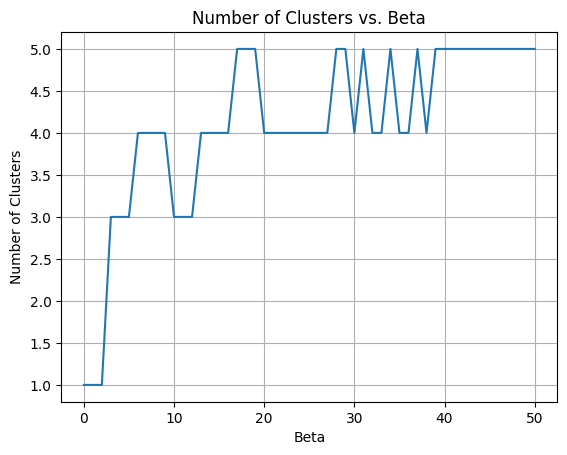

In [181]:
betas = np.linspace(0, 50, 51)
# Initialize an empty list to store the number of clusters
num_clusters_list = []

# Iterate over each beta value
for beta in betas:
    # Run iterative_algorithm to obtain q_t_given_x
    q_t_given_x, _, _ = geom_DIB_on_alternatives(p_xy, max_iter=5000, beta=beta, threshold=1e-4)
    
    # Calculate the number of clusters
    column_sum = np.sum(q_t_given_x, axis=0)
    num_clusters = np.count_nonzero(column_sum)
    
    # Append the number of clusters to the list
    num_clusters_list.append(num_clusters)

# Plot the number of clusters against beta values
plt.plot(betas, num_clusters_list)
plt.xlabel('Beta')
plt.ylabel('Number of Clusters')
plt.title('Number of Clusters vs. Beta')
plt.grid(True)
plt.show()